In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import utils
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Input, Dense, Flatten, Concatenate

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

import os

In [2]:
load_path = 'D:\GH\Audio\dataset\소리인식\dataset\zero_pad_preprocess1'

'''
loaded = np.load('파일명.npz')
loaded['spectrogram']
loaded['Mel_spectrogram']
loaded['Log_Mel_spectrogram']
loaded['mfcc']
loaded['delta_mfcc']
'''

for idx, file in enumerate(os.listdir(load_path)):
    filepath = os.path.join(load_path, file)
    loaded = np.load(filepath)
    print('class number :',idx, file[:-4])
    x = loaded['Log_Mel_spectrogram']
    y = np.zeros((x.shape[0],1), dtype=np.int8)
    y = y + idx
    print(x.shape)
    print(y.shape)
    ratio = round(x.shape[0]*0.2)   # 각 클래스별 나누는 비율
    flag = x.shape[0]-ratio

    if idx == 0:
        x_train = x[:flag]
        y_train = y[:flag]
        x_test = x[flag:]
        y_test = y[flag:]
    else:
        x_train = np.vstack((x_train, x[:flag]))
        y_train = np.vstack((y_train, y[:flag]))
        x_test = np.vstack((x_test, x[flag:]))
        y_test = np.vstack((y_test, y[flag:]))
        

class number : 0 b40 high
(72, 128, 311)
(72, 1)
class number : 1 b40 medium
(69, 128, 311)
(69, 1)
class number : 2 high priority alarm
(65, 128, 311)
(65, 1)
class number : 3 TE171 occlusion alarm
(76, 128, 311)
(76, 1)
class number : 4 transport advisory alarm
(71, 128, 311)
(71, 1)
class number : 5 transport crisis alarm
(71, 128, 311)
(71, 1)
class number : 6 transport warning alarm
(75, 128, 311)
(75, 1)
class number : 7 V300 high priority alarm
(70, 128, 311)
(70, 1)


In [3]:
x_train = x_train[...,np.newaxis]
x_test = x_test[...,np.newaxis]
y_train = y_train.reshape((-1,))
y_test = y_test.reshape((-1,))

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(456, 128, 311, 1)
(456,)
(113, 128, 311, 1)
(113,)


In [5]:
np.random.seed(0)

# 배열의 원소 개수만큼 인덱스 배열을 만든 후 
# 무작위로 뒤섞어 줍니다. 
idx_train = np.arange(x_train.shape[0])
idx_test = np.arange(x_test.shape[0])
# print(idx)
np.random.shuffle(idx_train)
np.random.shuffle(idx_test)

x_train_shuffle = x_train[idx_train]
y_train_shuffle = y_train[idx_train]
x_test_shuffle = x_test[idx_test]
y_test_shuffle = y_test[idx_test]

In [6]:
print(x_train_shuffle.shape)
print(y_train_shuffle.shape)
print(x_test_shuffle.shape)
print(y_test_shuffle.shape)

(456, 128, 311, 1)
(456,)
(113, 128, 311, 1)
(113,)


# P.T. ResNet50

In [7]:
# Create the base model from the pre-trained model Resnet-50
# ResNet50 불러오기에서 include_top=을 True가 아닌 False로 둠으로써 사전학습된 모델의 최상층 분류기를 사용하지 않겠다고 설정
# include_top을 True로 설정하면 크기는 224,224,3으로 제한

IMG_SHAPE = (128, 311) + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [8]:
# base_model.trainable = False를 통해 사전학습된 resnet이 기존에 기억하던 weights를 손상주지 않기 위해 동결

base_model.trainable = False

In [9]:
# ResNet50 입력을 변환하여 모델 설계
# inputs = Input((28, 28, 1))
# resized_x = tf.keras.layers.experimental.preprocessing.Resizing(32, 32)(inputs)
# first_conv_layer = Conv2D(3, 1, padding='same', activation=None)(resized_x)

inputs = Input((128, 311, 1))
first_conv_layer = Conv2D(3, 1, padding='same', activation=None)(inputs)

x = base_model(first_conv_layer, training = False)
x = Flatten()(x)
outputs = Dense(8, activation = 'softmax')(x)

model = tf.keras.Model(inputs, outputs, name="P_T_resnet50_model")

In [10]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001), 
              metrics=['accuracy'])

# early stopping 설정
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.summary()

Model: "P_T_resnet50_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 311, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 311, 3)       6         
                                                                 
 resnet50 (Functional)       (None, 4, 10, 2048)       23587712  
                                                                 
 flatten (Flatten)           (None, 81920)             0         
                                                                 
 dense (Dense)               (None, 8)                 655368    
                                                                 
Total params: 24,243,086
Trainable params: 655,374
Non-trainable params: 23,587,712
_________________________________________________________________


In [11]:
# 모델 fitting
hist = model.fit(x_train_shuffle, y_train_shuffle,
                 validation_data = (x_test, y_test),
                 epochs = 15,
                 batch_size = 128,
                 verbose = 1,
                 callbacks=[early])

Epoch 1/15
4/4 [==============================] - 19s 2s/step - loss: 4.0479 - accuracy: 0.4364 - val_loss: 0.1800 - val_accuracy: 0.9115
Epoch 2/15
4/4 [==============================] - 2s 489ms/step - loss: 0.3812 - accuracy: 0.8750 - val_loss: 0.7229 - val_accuracy: 0.8407
Epoch 3/15
4/4 [==============================] - 2s 502ms/step - loss: 0.3105 - accuracy: 0.9320 - val_loss: 8.2280e-05 - val_accuracy: 1.0000
Epoch 4/15
4/4 [==============================] - 2s 493ms/step - loss: 0.0177 - accuracy: 0.9978 - val_loss: 1.0510e-04 - val_accuracy: 1.0000
Epoch 5/15
4/4 [==============================] - 2s 491ms/step - loss: 0.0594 - accuracy: 0.9846 - val_loss: 4.0729e-05 - val_accuracy: 1.0000
Epoch 6/15
4/4 [==============================] - 2s 502ms/step - loss: 0.0130 - accuracy: 0.9956 - val_loss: 2.0466e-07 - val_accuracy: 1.0000
Epoch 7/15
4/4 [==============================] - 2s 486ms/step - loss: 0.0021 - accuracy: 0.9978 - val_loss: 7.1525e-07 - val_accuracy: 1.0000
Ep

## 전이학습 미세조정(fine tuning)

In [12]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 311, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 317, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 156, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 156, 64)  256         ['conv1_conv[0][0]']      

In [13]:
len(base_model.layers)

175

In [14]:
# 동결 layer 비율: 20%
ratio = round(len(base_model.layers) * 0.2)
flag = len(base_model.layers) - ratio
print(flag)

140


In [15]:
base_model.trainable = True		# resnet 모델 학습동결을 해제한다
for i in base_model.layers[:flag]:	# 140층까지 레이어를 불러서, 
  i.trainable = False				# 이전까지의 학습은 동결한다.
  
for i in base_model.layers[135:145]:	# 동결이 제대로 해제됐는지 약간 이전층부터 출력해본다.
  print(i.name, i.trainable)

conv4_block6_1_relu False
conv4_block6_2_conv False
conv4_block6_2_bn False
conv4_block6_2_relu False
conv4_block6_3_conv False
conv4_block6_3_bn True
conv4_block6_add True
conv4_block6_out True
conv5_block1_1_conv True
conv5_block1_1_bn True


In [16]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001), 
              metrics=['accuracy'])

early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.summary()

# model_res.summary() 결과, 맨 아래쪽 Trainable params의 수치가 눈에 띄게 늘어난 것을 볼 수 있다.

Model: "P_T_resnet50_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 311, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 311, 3)       6         
                                                                 
 resnet50 (Functional)       (None, 4, 10, 2048)       23587712  
                                                                 
 flatten (Flatten)           (None, 81920)             0         
                                                                 
 dense (Dense)               (None, 8)                 655368    
                                                                 
Total params: 24,243,086
Trainable params: 15,633,422
Non-trainable params: 8,609,664
_________________________________________________________________


In [17]:
hist_fine = model.fit(x_train_shuffle, y_train_shuffle,
                      validation_data = (x_test, y_test),
                      epochs = 15,
                      batch_size = 128,
                      verbose = 1,
                      callbacks=[early])

Epoch 1/15
4/4 [==============================] - 9s 1s/step - loss: 28.2740 - accuracy: 0.5022 - val_loss: 19.0181 - val_accuracy: 0.2478
Epoch 2/15
4/4 [==============================] - 2s 553ms/step - loss: 13.3967 - accuracy: 0.3026 - val_loss: 4.5017 - val_accuracy: 0.2655
Epoch 3/15
4/4 [==============================] - 2s 559ms/step - loss: 3.8246 - accuracy: 0.5921 - val_loss: 1.1734 - val_accuracy: 0.6283
Epoch 4/15
4/4 [==============================] - 2s 545ms/step - loss: 0.8277 - accuracy: 0.7851 - val_loss: 0.2654 - val_accuracy: 0.8761
Epoch 5/15
4/4 [==============================] - 2s 554ms/step - loss: 0.1120 - accuracy: 0.9496 - val_loss: 0.0366 - val_accuracy: 0.9912
Epoch 6/15
4/4 [==============================] - 2s 564ms/step - loss: 0.0548 - accuracy: 0.9825 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 7/15
4/4 [==============================] - 2s 555ms/step - loss: 0.0308 - accuracy: 0.9803 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 8/15
4/4 [====

## 전이학습 모델의 구조만 가져와서 학습

In [18]:
base_model_noWeight = tf.keras.applications.ResNet50(include_top=False, pooling = 'avg' , input_shape = (128, 311, 3), weights = None)

base_model_noWeight.trainable =True

In [19]:
# ResNet50 입력을 변환하여 모델 설계
# inputs = Input((28, 28, 1))
# resized_x = tf.keras.layers.experimental.preprocessing.Resizing(32, 32)(inputs)
# first_conv_layer = Conv2D(3, 1, padding='same', activation=None)(resized_x)

inputs = Input((128, 311, 1))
first_conv_layer = Conv2D(3, 1, padding='same', activation=None)(inputs)

x = base_model_noWeight(first_conv_layer, training = False)
x = Flatten()(x)
outputs = Dense(8, activation = 'softmax')(x)

model = tf.keras.Model(inputs, outputs, name="Scratch_resnet50_model")

In [20]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001), 
              metrics=['accuracy'])

early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.summary()

# model_res.summary() 결과, 맨 아래쪽 Trainable params의 수치가 눈에 띄게 늘어난 것을 볼 수 있다.

Model: "Scratch_resnet50_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 311, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 311, 3)       6         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 8)                 16392     
                                                                 
Total params: 23,604,110
Trainable params: 23,550,990
Non-trainable params: 53,120
_________________________________________________________________


In [21]:
hist_scratch = model.fit(x_train_shuffle, y_train_shuffle,
                      validation_data = (x_test, y_test),
                      epochs = 30,
                      batch_size = 128,
                      verbose = 1,
                      callbacks=[early])

Epoch 1/30
4/4 [==============================] - 13s 1s/step - loss: 69.5301 - accuracy: 0.0833 - val_loss: 2.7652 - val_accuracy: 0.1327
Epoch 2/30
4/4 [==============================] - 3s 672ms/step - loss: 2.3081 - accuracy: 0.1425 - val_loss: 2.0646 - val_accuracy: 0.1327
Epoch 3/30
4/4 [==============================] - 3s 681ms/step - loss: 2.0791 - accuracy: 0.1053 - val_loss: 2.0603 - val_accuracy: 0.1327
Epoch 4/30
4/4 [==============================] - 3s 678ms/step - loss: 2.0730 - accuracy: 0.1316 - val_loss: 2.0472 - val_accuracy: 0.1327
Epoch 5/30
4/4 [==============================] - 3s 678ms/step - loss: 2.0421 - accuracy: 0.1272 - val_loss: 2.0335 - val_accuracy: 0.1239
Epoch 6/30
4/4 [==============================] - 3s 674ms/step - loss: 2.0406 - accuracy: 0.1228 - val_loss: 1.9971 - val_accuracy: 0.1327
Epoch 7/30
4/4 [==============================] - 3s 675ms/step - loss: 1.9892 - accuracy: 0.2149 - val_loss: 1.9398 - val_accuracy: 0.1239
Epoch 8/30
4/4 [=====

## 모델 학습 기록

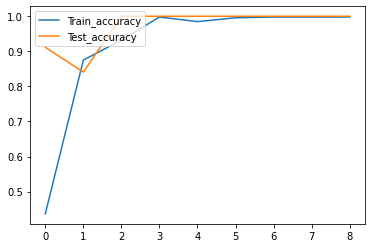

In [26]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드
plt.plot(hist.history['accuracy'], label='Train_accuracy')
plt.plot(hist.history['val_accuracy'], label='Test_accuracy')
plt.legend(loc='upper left')
plt.show()

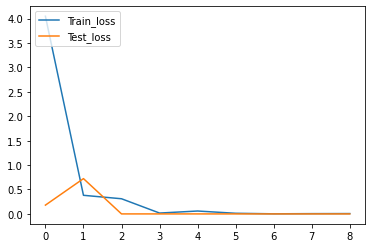

In [25]:
# hist의 loss plt의 plot을 이용하여 출력하는 코드
plt.plot(hist.history['loss'], label='Train_loss')
plt.plot(hist.history['val_loss'], label='Test_loss')
plt.legend(loc='upper left')
plt.show()

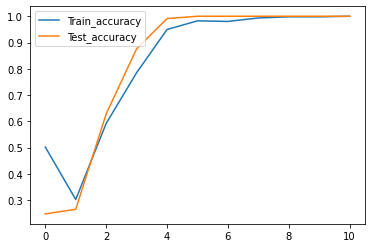

In [27]:
# hist_fine의 accuracy plt의 plot을 이용하여 출력하는 코드
plt.plot(hist_fine.history['accuracy'], label='Train_accuracy')
plt.plot(hist_fine.history['val_accuracy'], label='Test_accuracy')
plt.legend(loc='upper left')
plt.show()

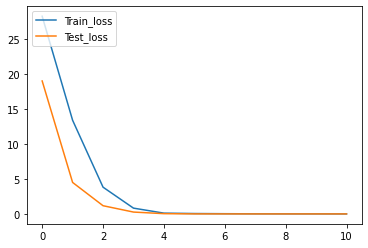

In [28]:
# hist_fine의 loss plt의 plot을 이용하여 출력하는 코드
plt.plot(hist_fine.history['loss'], label='Train_loss')
plt.plot(hist_fine.history['val_loss'], label='Test_loss')
plt.legend(loc='upper left')
plt.show()

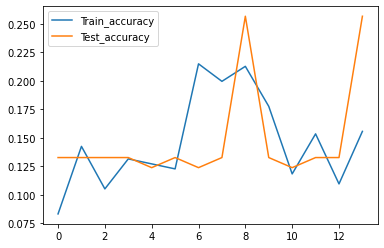

In [30]:
# hist_scratch의 accuracy plt의 plot을 이용하여 출력하는 코드
plt.plot(hist_scratch.history['accuracy'], label='Train_accuracy')
plt.plot(hist_scratch.history['val_accuracy'], label='Test_accuracy')
plt.legend(loc='upper left')
plt.show()

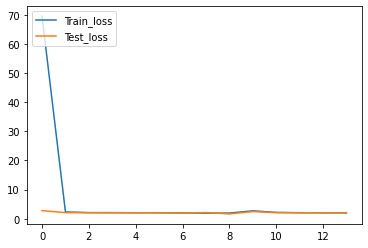

In [29]:
# hist_scratch의 loss plt의 plot을 이용하여 출력하는 코드
plt.plot(hist_scratch.history['loss'], label='Train_loss')
plt.plot(hist_scratch.history['val_loss'], label='Test_loss')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# 모델을 저장하는 코드
# model.save('./P_T_resnet50_scratch_model.h5')